In [1]:
from matplotlib import pyplot as plt
from matplotlib.dates import MonthLocator, num2date
from matplotlib.ticker import FuncFormatter
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import add_changepoints_to_plot

import pandas as pd
import numpy as np
import datetime as dt
from collections import defaultdict
import time
import datetime as dt
from pytz import timezone
tz = timezone('EST')
from tqdm import tqdm

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

import seaborn as sns
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import style
sns.set()

In [2]:
semass2011 = pd.ExcelFile(r"C:\Users\Rohan\Desktop\Big Data\Load Data\smd_hourly_2011_2022\2011_smd_hourly.xls")
semass2011 = pd.read_excel(semass2011, 'SEMASS')
semass2012 = pd.ExcelFile(r"C:\Users\Rohan\Desktop\Big Data\Load Data\smd_hourly_2011_2022\2012_smd_hourly.xls")
semass2012 = pd.read_excel(semass2012, 'SEMASS')
semass2013 = pd.ExcelFile(r"C:\Users\Rohan\Desktop\Big Data\Load Data\smd_hourly_2011_2022\2013_smd_hourly.xls")
semass2013 = pd.read_excel(semass2013, 'SEMASS')
semass2014 = pd.ExcelFile(r"C:\Users\Rohan\Desktop\Big Data\Load Data\smd_hourly_2011_2022\2014_smd_hourly.xls")
semass2014 = pd.read_excel(semass2014, 'SEMASS')
semass2015 = pd.ExcelFile(r"C:\Users\Rohan\Desktop\Big Data\Load Data\smd_hourly_2011_2022\2015_smd_hourly.xls")
semass2015 = pd.read_excel(semass2015, 'SEMASS')
semass2016 = pd.ExcelFile(r"C:\Users\Rohan\Desktop\Big Data\Load Data\smd_hourly_2011_2022\2016_smd_hourly.xls")
semass2016 = pd.read_excel(semass2016, 'SEMA')

In [3]:
semass2017 = pd.read_excel(r"C:\Users\Rohan\Desktop\Big Data\Load Data\smd_hourly_2011_2022\2017_smd_hourly.xlsx", 'SEMA')
semass2018 = pd.read_excel(r"C:\Users\Rohan\Desktop\Big Data\Load Data\smd_hourly_2011_2022\2018_smd_hourly.xlsx", 'SEMA')
semass2019 = pd.read_excel(r"C:\Users\Rohan\Desktop\Big Data\Load Data\smd_hourly_2011_2022\2019_smd_hourly.xlsx", 'SEMA')
semass2020 = pd.read_excel(r"C:\Users\Rohan\Desktop\Big Data\Load Data\smd_hourly_2011_2022\2020_smd_hourly.xlsx", 'SEMA')
semass2021 = pd.read_excel(r"C:\Users\Rohan\Desktop\Big Data\Load Data\smd_hourly_2011_2022\2021_smd_hourly.xlsx", 'SEMA')
semass2022 = pd.read_excel(r"C:\Users\Rohan\Desktop\Big Data\Load Data\smd_hourly_2011_2022\2022_smd_hourly.xlsx", 'SEMA')

In [4]:
semass2022

,Date,Hr_End,DA_Demand,RT_Demand,DA_LMP,DA_EC,DA_CC,DA_MLC,RT_LMP,RT_EC,RT_CC,RT_MLC,Dry_Bulb,Dew_Point
0,2022-01-01,1,1257.6,1269.542,32.81,32.35,0.22,0.24,26.13,25.95,0.0,0.18,45,45
1,2022-01-01,2,1216.9,1199.337,32.86,32.31,0.28,0.27,26.10,25.87,0.0,0.23,45,45
2,2022-01-01,3,1156.9,1153.599,31.05,30.85,0.00,0.20,27.75,27.50,0.0,0.25,45,45
3,2022-01-01,4,1140.4,1129.515,29.88,29.69,0.00,0.19,25.36,25.13,0.0,0.23,45,45
4,2022-01-01,5,1148.7,1128.633,31.06,30.86,0.00,0.20,29.53,29.27,0.0,0.26,45,45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
739,2022-01-31,20,2023.9,2139.115,228.11,226.40,0.00,1.71,297.40,295.80,0.0,1.60,20,9
740,2022-01-31,21,1933.2,2060.195,203.96,202.82,0.00,1.14,265.61,264.21,0.0,1.40,19,10
741,2022-01-31,22,1772.2,1942.939,185.11,183.42,0.00,1.69,253.18,251.93,0.0,1.25,17,10
742,2022-01-31,23,1656.1,1803.142,181.10,179.93,0.00,1.17,191.47,190.96,0.0,0.51,16,11


In [5]:
val2011 = semass2011['DEMAND']
val2012 = semass2012['DEMAND']
val2013 = semass2013['DEMAND']
val2014 = semass2014['DEMAND']
val2015 = semass2015['DEMAND']
val2016 = semass2016['RT_Demand']
val2017 = semass2017['RT_Demand']
val2018 = semass2018['RT_Demand']
val2019 = semass2019['RT_Demand']
val2020 = semass2020['RT_Demand']
val2021 = semass2021['RT_Demand']
val2022 = semass2022['RT_Demand']

In [6]:
values = [val2011, val2012, val2013, val2014, val2015, val2016, val2017, val2018, val2019, val2020, val2021, val2022]
values_df = pd.concat(values, axis=0, ignore_index=False)
values_df = values_df.reset_index()
period = len(values_df)

In [7]:
rng = pd.date_range('2011-01-01', periods=period, freq='1H')
date_df = pd.DataFrame({ 'ds': rng})
date_df = date_df.reset_index()

In [8]:
frames = [date_df, values_df]
semass_load = pd.concat(frames, axis=1, ignore_index=False)
semass_load = semass_load.rename(columns={semass_load.columns[1]: 'ds', semass_load.columns[3]: 'y'})
frames2 = [semass_load['ds'], semass_load['y']]
semass_load = pd.concat(frames2, axis=1, ignore_index=False)
semass_load

,ds,y
0,2011-01-01 00:00:00,1438.000
1,2011-01-01 01:00:00,1348.000
2,2011-01-01 02:00:00,1286.000
3,2011-01-01 03:00:00,1252.000
4,2011-01-01 04:00:00,1242.000
...,...,...
97171,2022-01-31 19:00:00,2139.115
97172,2022-01-31 20:00:00,2060.195
97173,2022-01-31 21:00:00,1942.939
97174,2022-01-31 22:00:00,1803.142


In [9]:
model = Prophet(
        changepoint_prior_scale=0.5, 
        seasonality_mode='multiplicative', 
        interval_width=0.95, 
    )
model.add_country_holidays(country_name='US')

In [10]:
model.fit(semass_load)

In [11]:
import json
from prophet.serialize import model_to_json, model_from_json

with open('semass_model.json', 'w') as fout:
    json.dump(model_to_json(model), fout)  # Save model

# Forecasting

In [ ]:
with open('semass_model.json', 'r') as fin:
    m = model_from_json(json.load(fin))  # Load model

In [12]:
future_pd = m.make_future_dataframe(
        periods=365, 
        freq='D',
        include_history=False
    )
    
# make predictions
forecast_pd = m.predict(future_pd)

In [13]:
forecast_pd[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
97536,2022-02-16 00:00:00,1426.971672,1039.208572,1807.200194
97537,2022-02-16 01:00:00,1350.727326,1003.248952,1729.392796
97538,2022-02-16 02:00:00,1307.367120,949.880895,1675.369753
97539,2022-02-16 03:00:00,1301.069964,934.501568,1664.933515
97540,2022-02-16 04:00:00,1340.636815,932.634856,1736.582344


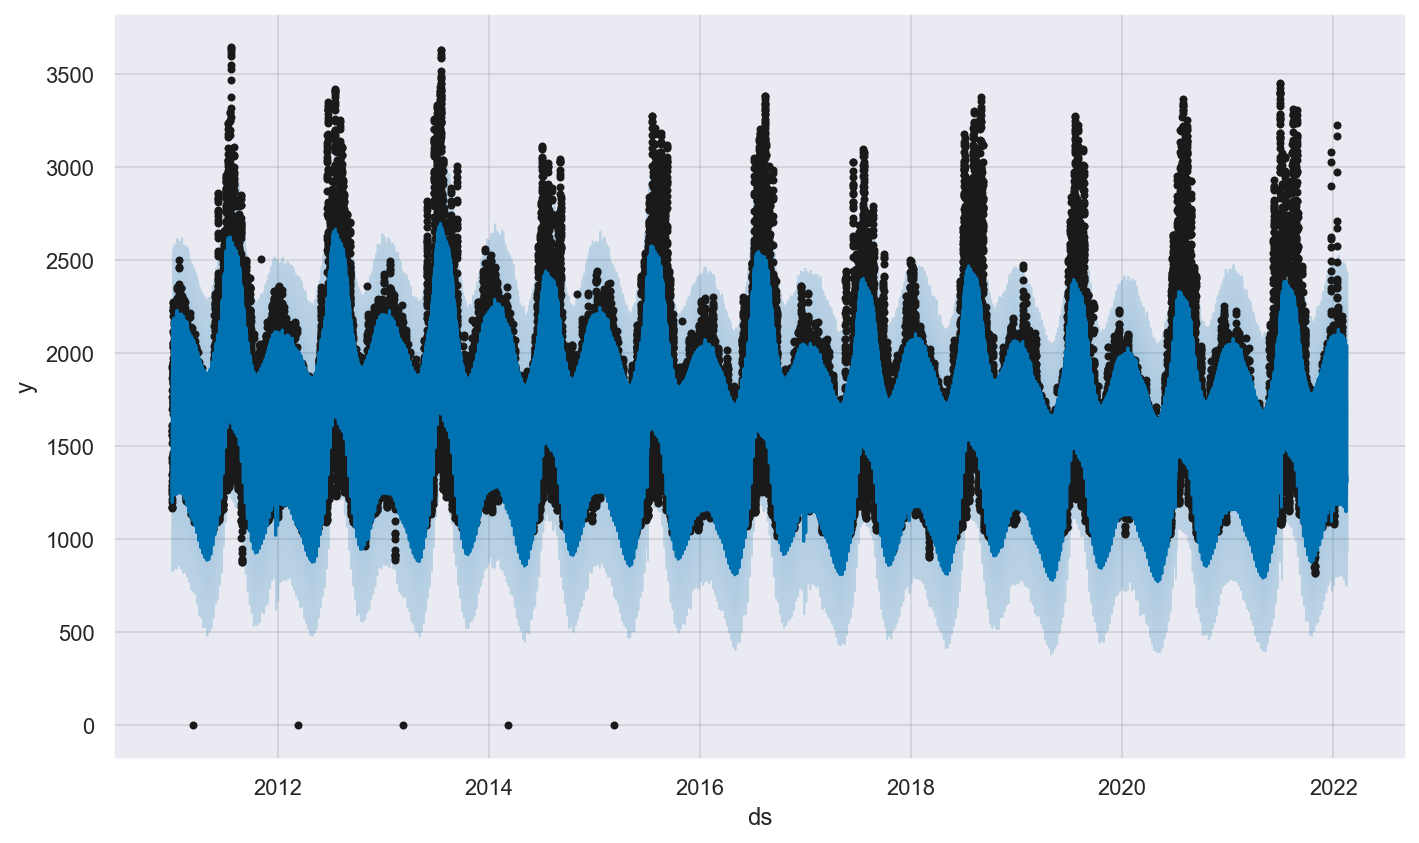

In [14]:
fig1 = model.plot(forecast_pd)

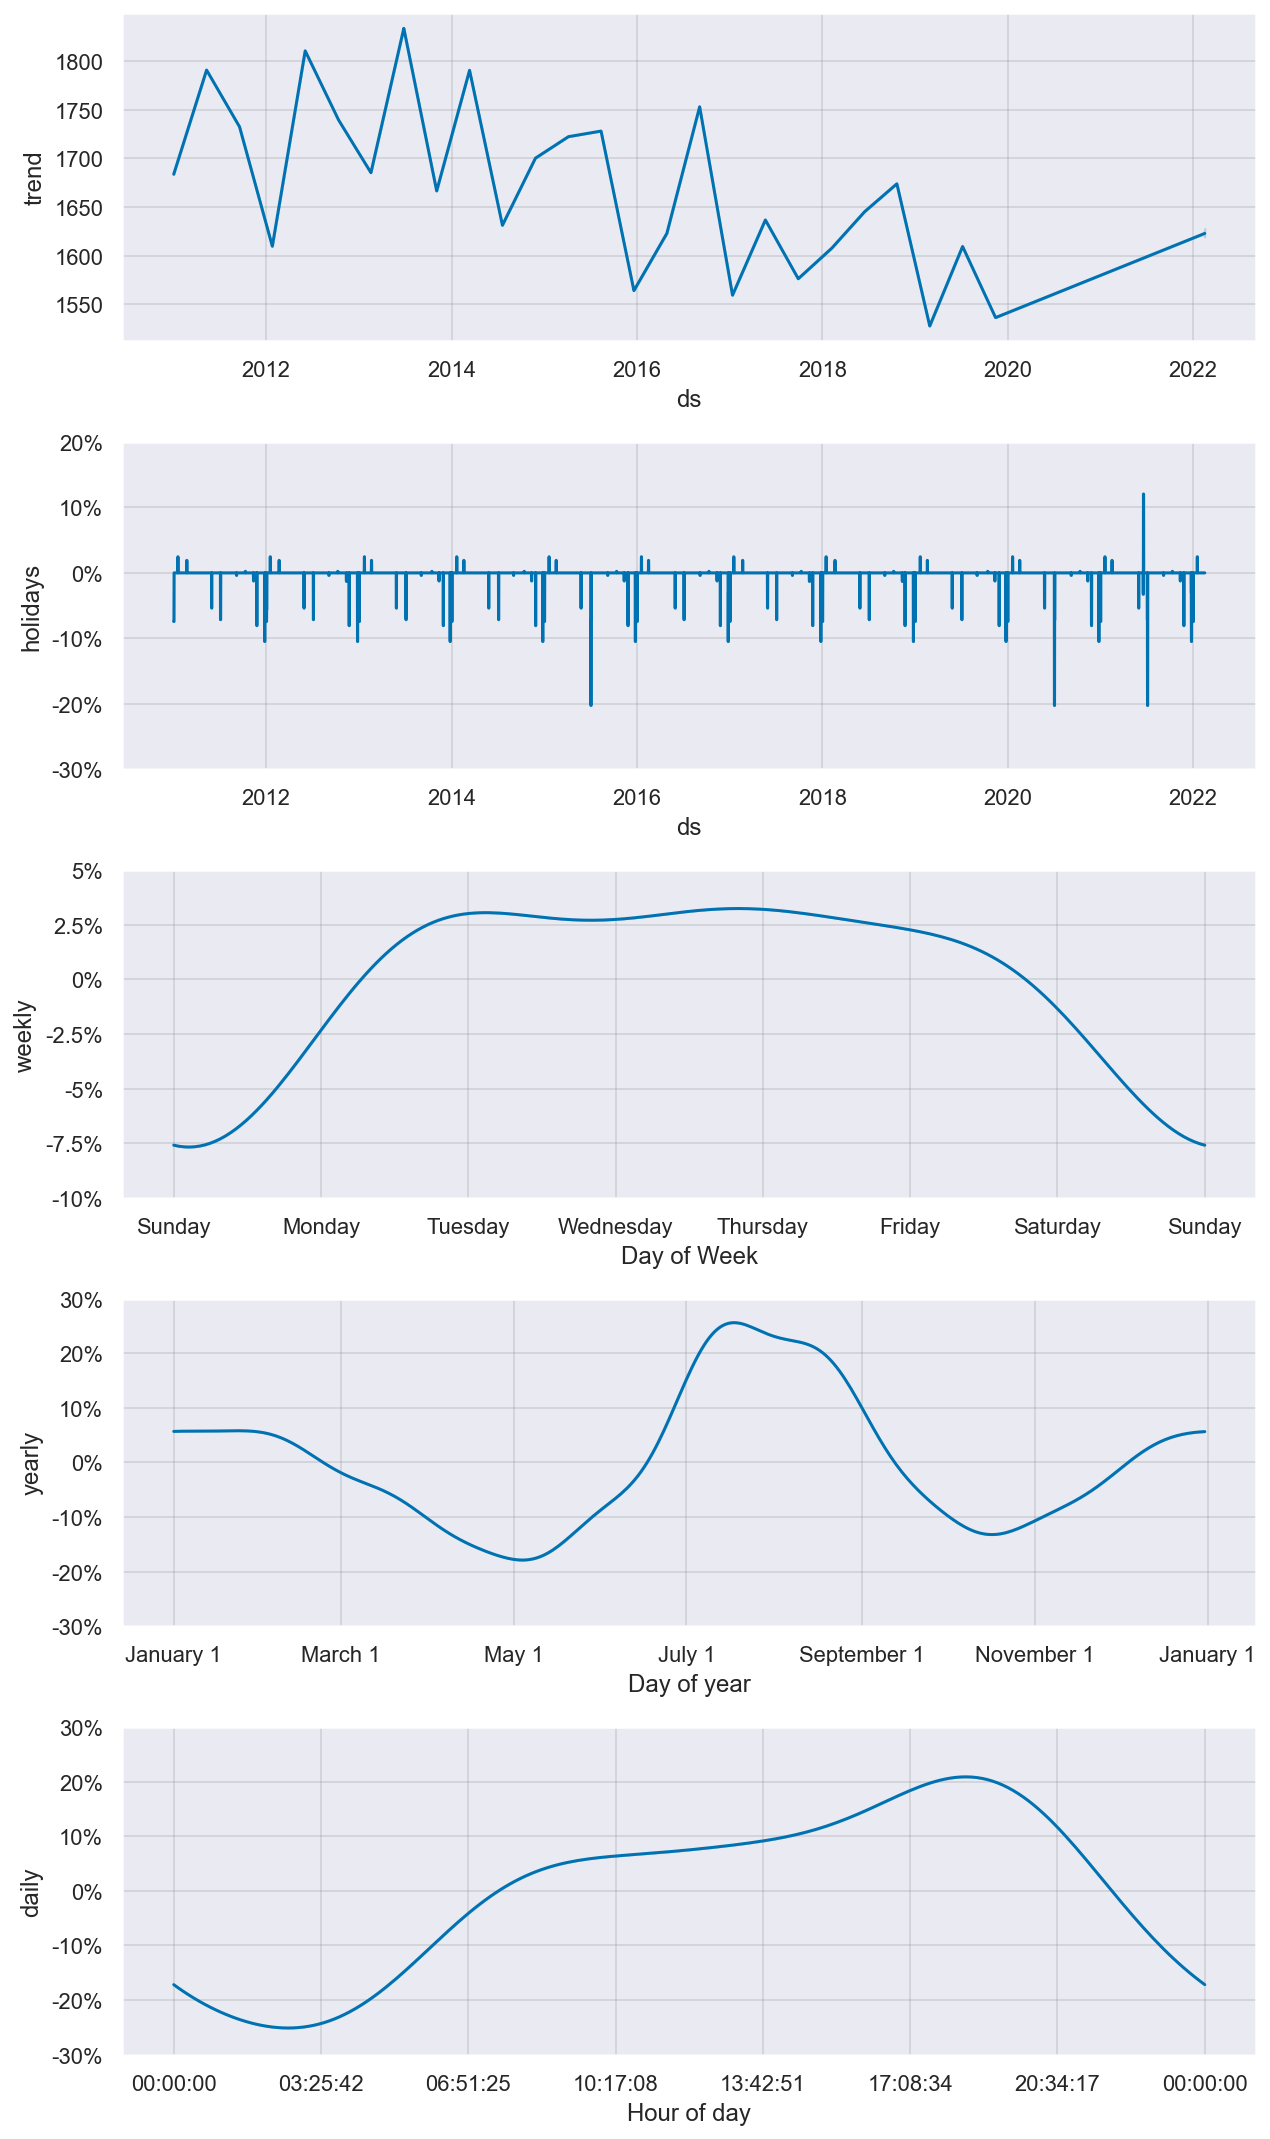

In [15]:
fig2 = model.plot_components(forecast_pd)

In [16]:
forecast_pd

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Christmas Day (Observed),...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2011-01-01 00:00:00,1683.556238,956.709070,1720.361468,1683.556238,1683.556238,0.0,0.0,0.0,0.0,...,-0.013437,-0.013437,-0.013437,0.056763,0.056763,0.056763,0.0,0.0,0.0,1342.160890
1,2011-01-01 01:00:00,1683.590692,880.208675,1642.450980,1683.590692,1683.590692,0.0,0.0,0.0,0.0,...,-0.016362,-0.016362,-0.016362,0.056772,0.056772,0.056772,0.0,0.0,0.0,1258.064673
2,2011-01-01 02:00:00,1683.625147,829.863216,1577.331687,1683.625147,1683.625147,0.0,0.0,0.0,0.0,...,-0.019375,-0.019375,-0.019375,0.056782,0.056782,0.056782,0.0,0.0,0.0,1207.870735
3,2011-01-01 03:00:00,1683.659601,827.987769,1575.766836,1683.659601,1683.659601,0.0,0.0,0.0,0.0,...,-0.022466,-0.022466,-0.022466,0.056792,0.056792,0.056792,0.0,0.0,0.0,1195.943638
4,2011-01-01 04:00:00,1683.694056,873.416783,1611.148052,1683.694056,1683.694056,0.0,0.0,0.0,0.0,...,-0.025623,-0.025623,-0.025623,0.056801,0.056801,0.056801,0.0,0.0,0.0,1231.446848
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97536,2022-02-16 00:00:00,1622.764795,1039.208572,1807.200194,1619.202485,1627.602753,0.0,0.0,0.0,0.0,...,0.027511,0.027511,0.027511,0.023605,0.023605,0.023605,0.0,0.0,0.0,1426.971672
97537,2022-02-16 01:00:00,1622.769168,1003.248952,1729.392796,1619.182639,1627.667468,0.0,0.0,0.0,0.0,...,0.027713,0.027713,0.027713,0.023469,0.023469,0.023469,0.0,0.0,0.0,1350.727326
97538,2022-02-16 02:00:00,1622.773540,949.880895,1675.369753,1619.162792,1627.732184,0.0,0.0,0.0,0.0,...,0.027951,0.027951,0.027951,0.023333,0.023333,0.023333,0.0,0.0,0.0,1307.367120
97539,2022-02-16 03:00:00,1622.777913,934.501568,1664.933515,1619.136337,1627.796899,0.0,0.0,0.0,0.0,...,0.028221,0.028221,0.028221,0.023197,0.023197,0.023197,0.0,0.0,0.0,1301.069964


In [17]:
forecast_pd.to_csv('semass_forecast.csv', index=False)

In [18]:
import joblib
 
# Save the model as a pickle in a file
joblib.dump(model, 'semass_model.pkl')

['semass_model.pkl']